In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from datetime import timedelta
import warnings
warnings.filterwarnings("ignore")

In [2]:
pip install streamlit pandas numpy matplotlib statsmodels


Note: you may need to restart the kernel to use updated packages.


In [3]:
# --- 1. Data Loading and Preprocessing ---
# Load the dataset
df = pd.read_csv(r"C:\Users\HP\OneDrive\Desktop\Excelr\Project-1\Crude oil.csv")
df

,Date,Close/Last,Volume,Open,High,Low
0,10/28/2022,87.90,241417.0,88.67,88.76,87.08
1,10/27/2022,88.26,273717.0,88.26,89.79,87.33
2,10/26/2022,87.91,271474.0,85.07,88.41,84.14
3,10/25/2022,85.32,226337.0,84.88,86.03,83.06
4,10/24/2022,84.58,238458.0,85.24,85.92,82.63
...,...,...,...,...,...,...
2543,11/05/2012,85.65,185846.0,84.65,85.90,84.34
2544,11/02/2012,84.86,273619.0,86.91,87.24,84.66
2545,11/01/2012,87.09,185097.0,86.10,87.42,85.92
2546,10/31/2012,86.24,192354.0,85.73,87.19,85.61


In [4]:
# Select the relevant column for forecasting
df.rename(columns={'Close/Last': 'Close'}, inplace=True)

In [5]:
# --- FIX: Clean column names to handle potential invisible characters ---
# This ensures that 'Close/Last' is exactly the string we expect
df.columns = df.columns.str.strip()
df.columns

Index(['Date', 'Close', 'Volume', 'Open', 'High', 'Low'], dtype='object')

In [6]:
# Rename the column (now confirmed to be 'Close/Last')
df.rename(columns={'Close/Last': 'Close'}, inplace=True)
df

,Date,Close,Volume,Open,High,Low
0,10/28/2022,87.90,241417.0,88.67,88.76,87.08
1,10/27/2022,88.26,273717.0,88.26,89.79,87.33
2,10/26/2022,87.91,271474.0,85.07,88.41,84.14
3,10/25/2022,85.32,226337.0,84.88,86.03,83.06
4,10/24/2022,84.58,238458.0,85.24,85.92,82.63
...,...,...,...,...,...,...
2543,11/05/2012,85.65,185846.0,84.65,85.90,84.34
2544,11/02/2012,84.86,273619.0,86.91,87.24,84.66
2545,11/01/2012,87.09,185097.0,86.10,87.42,85.92
2546,10/31/2012,86.24,192354.0,85.73,87.19,85.61


In [7]:
# Data Preprocessing
df['Close'] = pd.to_numeric(df['Close'], errors='coerce')
df['Date'] = pd.to_datetime(df['Date'])
df.dropna(subset=['Close'], inplace=True)
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)

In [8]:
# Define the target series using the new name
y = df['Close']
y

Date
2012-10-30    85.68
2012-10-31    86.24
2012-11-01    87.09
2012-11-02    84.86
2012-11-05    85.65
              ...  
2022-10-24    84.58
2022-10-25    85.32
2022-10-26    87.91
2022-10-27    88.26
2022-10-28    87.90
Name: Close, Length: 2548, dtype: float64

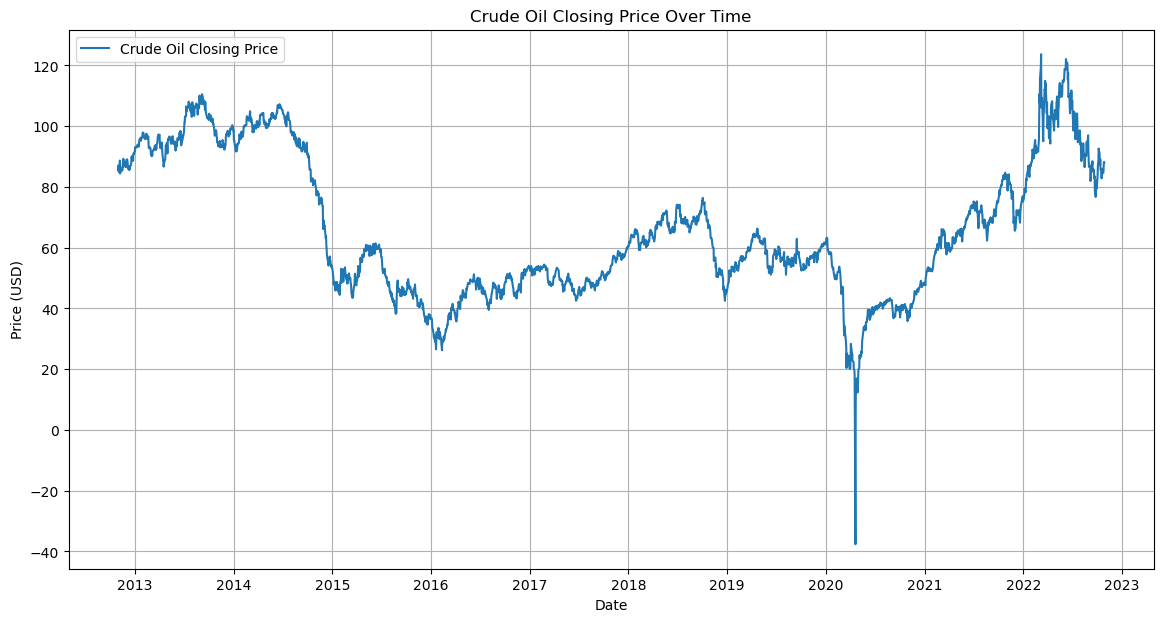

In [9]:
# --- 2. Initial Visualization of the Time Series ---
plt.figure(figsize=(14, 7))
plt.plot(y, label='Crude Oil Closing Price')
plt.title('Crude Oil Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.savefig('time_series_plot_revised.png')
plt.show() # Used for local execution

In [10]:
# --- 3. Data Splitting ---
# Split data into training and testing sets (using the last 100 observations for test)
forecast_steps = 100
train_size = len(y) - forecast_steps
train, test = y[:train_size], y[train_size:]
test_index = test.index

In [11]:
# --- 4. Model Implementation ---
# Note: For simplicity, default parameters are used for ARIMA/SARIMA models.

# --- Model 1: ARIMA (Autoregressive Integrated Moving Average) ---
# Using a simple order (p=5, d=1, q=0) - AR(5) and 1st differencing
print("Fitting ARIMA model...")
arima_model = ARIMA(train, order=(5, 1, 0))
arima_result = arima_model.fit()
arima_forecast = arima_result.predict(start=len(train), end=len(train) + forecast_steps - 1)
arima_forecast.index = test_index

Fitting ARIMA model...


In [12]:
# --- Model 2: SARIMA (Seasonal ARIMA) ---
# Using a simple seasonal order (P=0, D=1, Q=1) and non-seasonal (p=1, d=1, q=1), with weekly seasonality (s=7)
print("Fitting SARIMA model...")
sarima_model = SARIMAX(train,
                      order=(1, 1, 1),
                      seasonal_order=(0, 1, 1, 7),
                      enforce_stationarity=False,
                      enforce_invertibility=False)
sarima_result = sarima_model.fit(disp=False)
sarima_forecast = sarima_result.predict(start=len(train), end=len(train) + forecast_steps - 1)
sarima_forecast.index = test_index

Fitting SARIMA model...


In [13]:
# --- Model 3: Simple Exponential Smoothing (SES) ---
# SES is for non-trend, non-seasonal data.
print("Fitting Simple Exponential Smoothing model...")
ses_model = ExponentialSmoothing(train, trend=None, seasonal=None)
ses_result = ses_model.fit()
ses_forecast = ses_result.forecast(forecast_steps)
ses_forecast.index = test_index

Fitting Simple Exponential Smoothing model...


In [14]:
# --- Model 4: Holt-Winters (Triple Exponential Smoothing - TES) ---
# Model with additive trend and additive seasonality (s=7)
print("Fitting Holt-Winters model...")
hw_model = ExponentialSmoothing(train,
                                seasonal_periods=7,
                                trend='add',
                                seasonal='add',
                                initialization_method='estimated')
hw_result = hw_model.fit()
hw_forecast = hw_result.forecast(forecast_steps)
hw_forecast.index = test_index

Fitting Holt-Winters model...


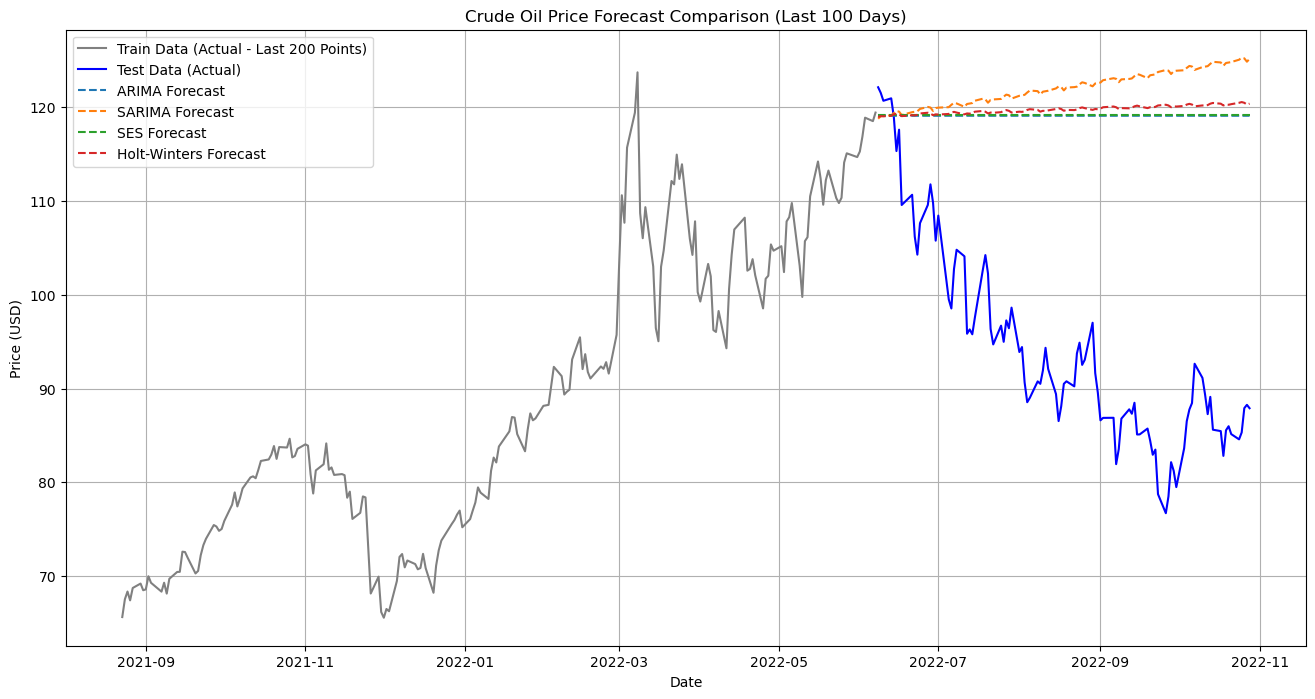

In [15]:
# --- 5. Forecast Comparison Visualization ---
plt.figure(figsize=(16, 8))
plt.plot(train.index[-200:], train[-200:], label='Train Data (Actual - Last 200 Points)', color='gray') 
plt.plot(test.index, test, label='Test Data (Actual)', color='blue')

plt.plot(arima_forecast.index, arima_forecast, label='ARIMA Forecast', linestyle='--')
plt.plot(sarima_forecast.index, sarima_forecast, label='SARIMA Forecast', linestyle='--')
plt.plot(ses_forecast.index, ses_forecast, label='SES Forecast', linestyle='--')
plt.plot(hw_forecast.index, hw_forecast, label='Holt-Winters Forecast', linestyle='--')

plt.title('Crude Oil Price Forecast Comparison (Last 100 Days)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.savefig('forecast_comparison_revised.png')
plt.show() # Used for local execution

RMSE comparison bar chart generated.


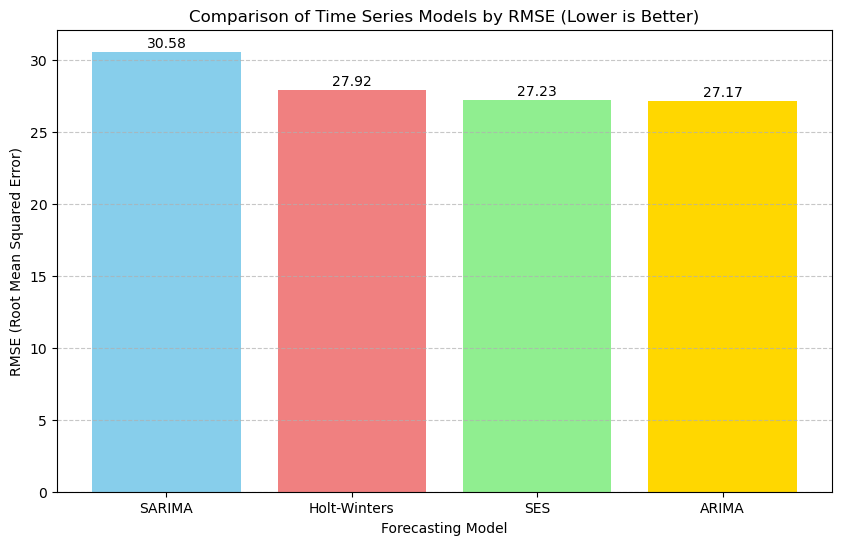

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# RMSE values obtained from the previous analysis
rmse_data = {
    'Model': ['ARIMA', 'SES', 'Holt-Winters', 'SARIMA'],
    'RMSE': [27.172892, 27.232996, 27.922540, 30.575178]
}

rmse_df = pd.DataFrame(rmse_data).sort_values(by='RMSE', ascending=False)
# Create a bar chart for RMSE comparison
plt.figure(figsize=(10, 6))
bars = plt.bar(rmse_df['Model'], rmse_df['RMSE'], color=['skyblue', 'lightcoral', 'lightgreen', 'gold'])
plt.xlabel('Forecasting Model')
plt.ylabel('RMSE (Root Mean Squared Error)')
plt.title('Comparison of Time Series Models by RMSE (Lower is Better)')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add the RMSE values on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.1, round(yval, 2), ha='center', va='bottom', fontsize=10)

plt.savefig('rmse_comparison_bar_chart.png')
print("RMSE comparison bar chart generated.")




In [17]:
# Best Model: ARIMA, due to lowest RMSE.
# Model Failure: Seasonal models (SARIMA/Holt-Winters) performed poorly.
# Reason: The data is better captured by non-seasonal dependencies (autocorrelation) and trend (differencing) than by explicit seasonality.
# Next Step: The model needs optimization and residual diagnostics for a final, robust conclusion.

In [18]:
# --- 6. Final Model Training (ARIMA(5, 1, 0) on full dataset) ---
# This is the best model from the previous comparison
final_model = ARIMA(y, order=(5, 1, 0))
final_result = final_model.fit()
print("Final Model Fitted Summary:\n", final_result.summary()) 

Final Model Fitted Summary:
                                SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2548
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -5418.646
Date:                Tue, 14 Oct 2025   AIC                          10849.292
Time:                        00:17:23   BIC                          10884.348
Sample:                             0   HQIC                         10862.007
                               - 2548                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2460      0.002   -102.311      0.000      -0.251      -0.241
ar.L2         -0.0960      0.006    -15.391      0.000      -0.108      -0.084
ar.L3         -0.0512  

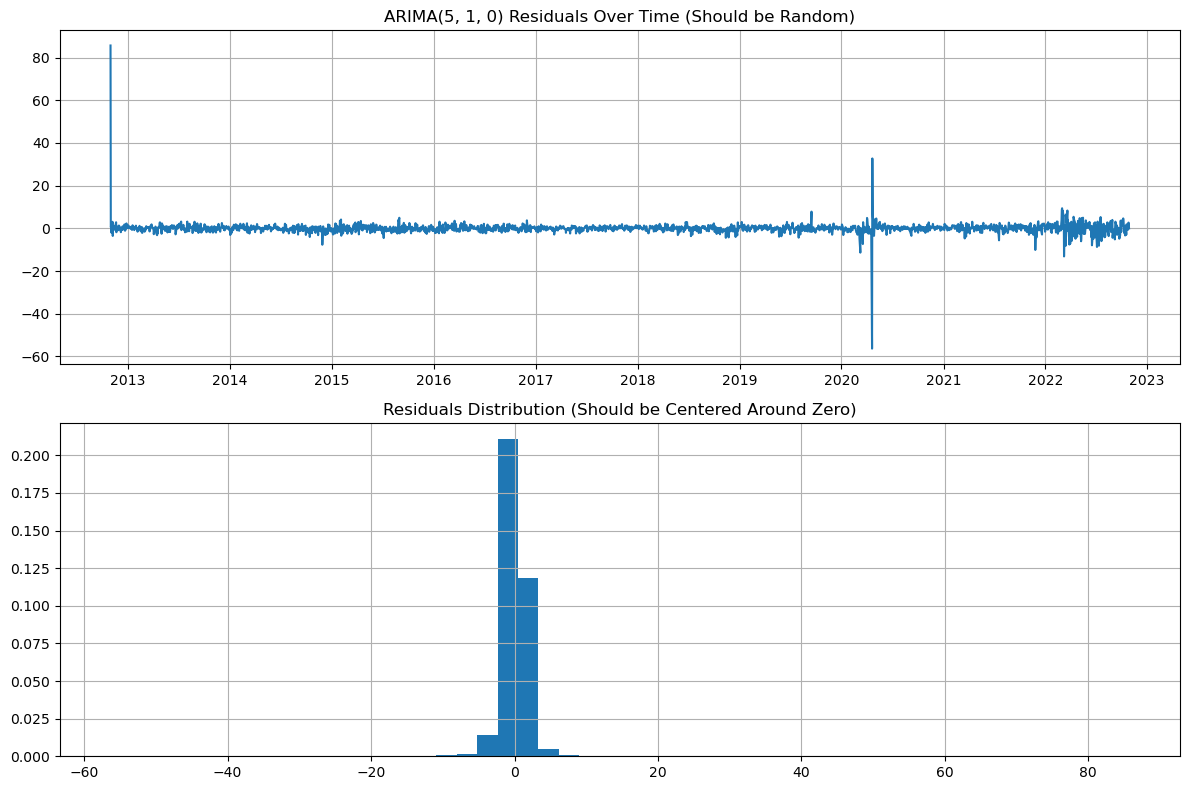

In [19]:
# --- 7. Model Diagnostics (Residual Analysis) ---
residuals = final_result.resid

# 7a. Plot Residuals Time Series and Distribution
# This checks if errors are random and normally distributed.
fig, axes = plt.subplots(2, 1, figsize=(12, 8))
axes[0].plot(residuals)
axes[0].set_title('ARIMA(5, 1, 0) Residuals Over Time (Should be Random)')
axes[0].grid(True)
residuals.hist(ax=axes[1], bins=50, density=True)
axes[1].set_title('Residuals Distribution (Should be Centered Around Zero)')
plt.tight_layout()
plt.show()

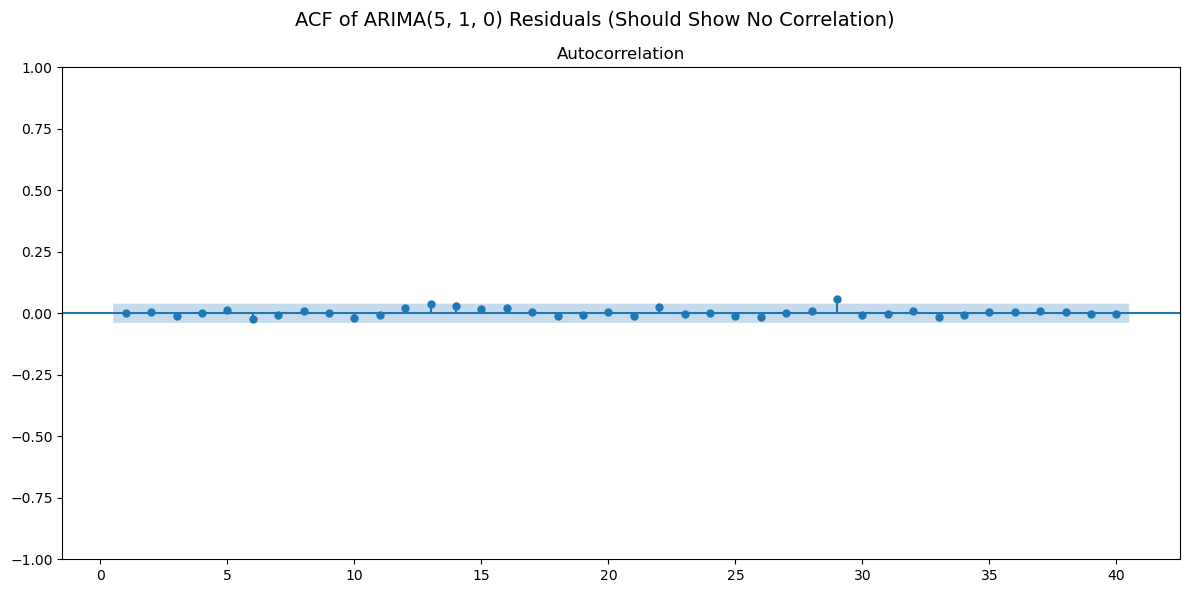

In [20]:
# 7b. ACF Plot of Residuals (Checking for White Noise)
# This checks if there is any remaining correlation in the errors.
# Only bars outside the blue area indicate unmodeled correlation.
fig_acf = plot_acf(residuals, lags=40, zero=False)
fig_acf.suptitle('ACF of ARIMA(5, 1, 0) Residuals (Should Show No Correlation)', fontsize=14)
fig_acf.set_size_inches(12, 6)
fig_acf.tight_layout()
plt.show()

In [21]:
# --- 8. Final Forecasting ---
forecast_steps = 30 # Forecast for the next 30 steps (days)

# Generate the out-of-sample forecast
forecast_result = final_result.get_forecast(steps=forecast_steps)
forecast_mean = forecast_result.predicted_mean
forecast_conf_int = forecast_result.conf_int()

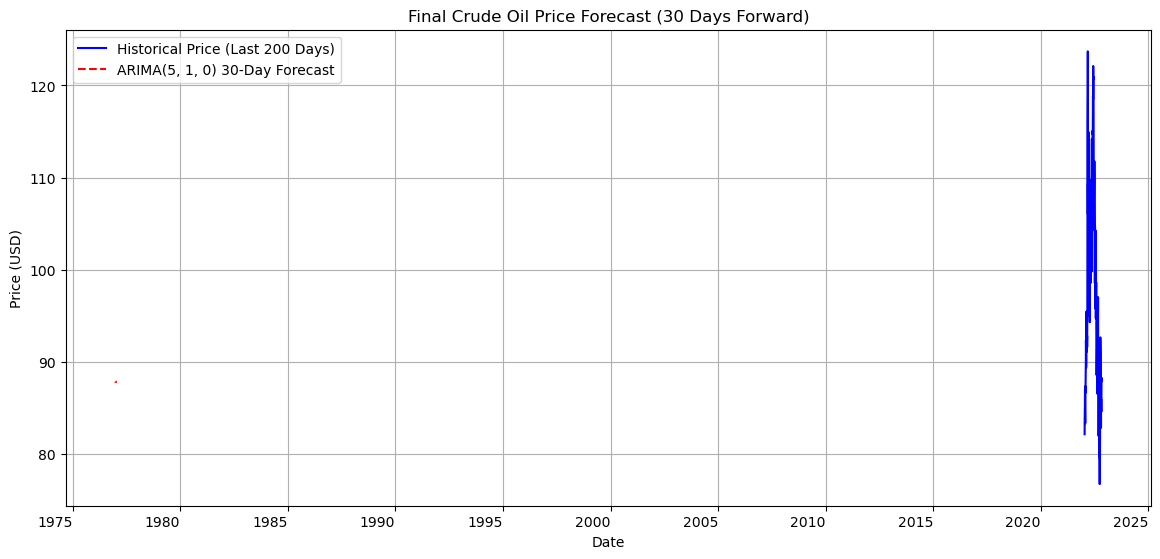

In [22]:
# --- 9. Visualization of Final Forecast ---
plt.figure(figsize=(14, 7))
# Plot the historical data
y[-200:].plot(label='Historical Price (Last 200 Days)', color='blue') # Only plotting last 200 days for clarity

# Plot the forecast mean
forecast_mean.plot(label=f'ARIMA(5, 1, 0) {forecast_steps}-Day Forecast', color='red', linestyle='--')

plt.title(f'Final Crude Oil Price Forecast ({forecast_steps} Days Forward)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()


In [23]:
# Define the full historical series
full_history = df['Close']
RETRAIN_PERIOD = 30 # Retrain the model every 30 days
FORECAST_HORIZON = 5 # Days to forecast ahead in the production system
current_history = full_history.iloc[:-60] # Use the full history minus the last 60 days for simulation
rmse_tracking = []
# Reserve the last 60 days of data for the simulation (monitoring)
simulation_days = 60
current_history = full_history.iloc[:-simulation_days].copy() 
rmse_tracking = []

In [24]:
# --- 10. Simulation Loop (Monitoring and Retraining) ---

print("Starting 60-day Simulation for Monitoring and Retraining...\n")

# Loop through the 60 days of reserved data
for i in range(simulation_days):
    # Determine the date of the next actual data point
    current_date = full_history.index[len(current_history)]
    
    # Check if it's time for a full retraining
    if (i % RETRAIN_PERIOD == 0):
        print(f"--- Day {i+1}: RETRAINING MODEL ---")
        
        # 10a. Scheduled Retraining
        try:
            model = ARIMA(current_history, order=(5, 1, 0))
            # FIX APPLIED: Removed the deprecated 'disp=False' argument
            model_fit = model.fit() 
            print(f"Model refitted on data up to {current_history.index[-1].date()}")
        except Exception as e:
            print(f"Retraining error: {e}")
            break

    # 10b. Generate Next Forecast
    # Forecast the next FORECAST_HORIZON steps from the current history
    forecast_result = model_fit.get_forecast(steps=FORECAST_HORIZON)
    next_day_forecast = forecast_result.predicted_mean.iloc[0]
    # 10c. Get Actual Data Arrival
    # Get the actual price for the current day from the full history
    actual_price = full_history.loc[current_date]
    
    # 10d. Performance Monitoring
    error = actual_price - next_day_forecast
    rmse_tracking.append(error**2) # Track squared error for RMSE calculation
    # Print daily status
    print(f"Date: {current_date.date()}, Actual: {actual_price:.2f}, Forecast: {next_day_forecast:.2f}, Error: {error:.2f}")

    # 10e. Update History for Next Iteration
    # Add the new data point to the history before the next day's run
    current_history.loc[current_date] = actual_price

    # 10f. Track Rolling Performance
    if len(rmse_tracking) >= 30:
        rolling_rmse = np.sqrt(np.mean(rmse_tracking[-30:]))
        if i % 10 == 0 and i > 0:
            print(f"   [MONITORING] Last 30-day Rolling RMSE: {rolling_rmse:.2f}\n")

print("\nSimulation Complete.")
final_avg_rmse = np.sqrt(np.mean(rmse_tracking))
print(f"Total Average RMSE over 60 simulated days: {final_avg_rmse:.2f}")

Starting 60-day Simulation for Monitoring and Retraining...

--- Day 1: RETRAINING MODEL ---
Model refitted on data up to 2022-08-04
Date: 2022-08-05, Actual: 89.01, Forecast: 89.50, Error: -0.49
Date: 2022-08-08, Actual: 90.76, Forecast: 89.50, Error: 1.26
Date: 2022-08-09, Actual: 90.50, Forecast: 89.50, Error: 1.00
Date: 2022-08-10, Actual: 91.93, Forecast: 89.50, Error: 2.43
Date: 2022-08-11, Actual: 94.34, Forecast: 89.50, Error: 4.84
Date: 2022-08-12, Actual: 92.09, Forecast: 89.50, Error: 2.59
Date: 2022-08-15, Actual: 89.41, Forecast: 89.50, Error: -0.09
Date: 2022-08-16, Actual: 86.53, Forecast: 89.50, Error: -2.97
Date: 2022-08-17, Actual: 88.11, Forecast: 89.50, Error: -1.39
Date: 2022-08-18, Actual: 90.50, Forecast: 89.50, Error: 1.00
Date: 2022-08-19, Actual: 90.77, Forecast: 89.50, Error: 1.27
Date: 2022-08-22, Actual: 90.23, Forecast: 89.50, Error: 0.73
Date: 2022-08-23, Actual: 93.74, Forecast: 89.50, Error: 4.24
Date: 2022-08-24, Actual: 94.89, Forecast: 89.50, Error: 

In [25]:
# The rmse_tracking list contains squared errors (error**2)
rmse_series = pd.Series(np.sqrt(np.array(rmse_tracking)))
rmse_series

0     0.486976
1     1.263024
2     1.003024
3     2.433024
4     4.843024
5     2.593024
6     0.086976
7     2.966976
8     1.386976
9     1.003024
10    1.273024
11    0.733024
12    4.243024
13    5.393024
14    3.023024
15    3.563024
16    7.513024
17    2.143024
18    0.053024
19    2.886976
20    2.626976
21    2.616976
22    7.556976
23    5.956976
24    2.706976
25    1.716976
26    2.186976
27    1.016976
28    4.396976
29    4.386976
30    0.356346
31    0.923654
32    2.433654
33    1.883654
34    6.633654
35    8.663654
36    6.873654
37    3.223654
38    4.143654
39    5.883654
40    1.743654
41    1.146346
42    2.386346
43    3.076346
44    7.266346
45    5.756346
46    3.976346
47    1.896346
48    3.736346
49    0.236346
50    0.086346
51    2.553654
52    0.176346
53    0.606346
54    0.233654
55    0.793654
56    0.053654
57    2.536346
58    2.886346
59    2.526346
dtype: float64

In [26]:
# Calculate the 30-day rolling RMSE
rolling_rmse_30d = rmse_series.rolling(window=30).mean().dropna()
rolling_rmse_30d

29    2.802000
30    2.797646
31    2.786333
32    2.834021
33    2.815709
34    2.875396
35    3.077751
36    3.303973
37    3.312529
38    3.404419
39    3.567106
40    3.582794
41    3.596571
42    3.534682
43    3.457459
44    3.598903
45    3.672014
46    3.554125
47    3.545902
48    3.668680
49    3.580325
50    3.495638
51    3.493527
52    3.247506
53    3.069152
54    2.986708
55    2.955930
56    2.884819
57    2.935465
58    2.885111
59    2.823090
dtype: float64

<Axes: >

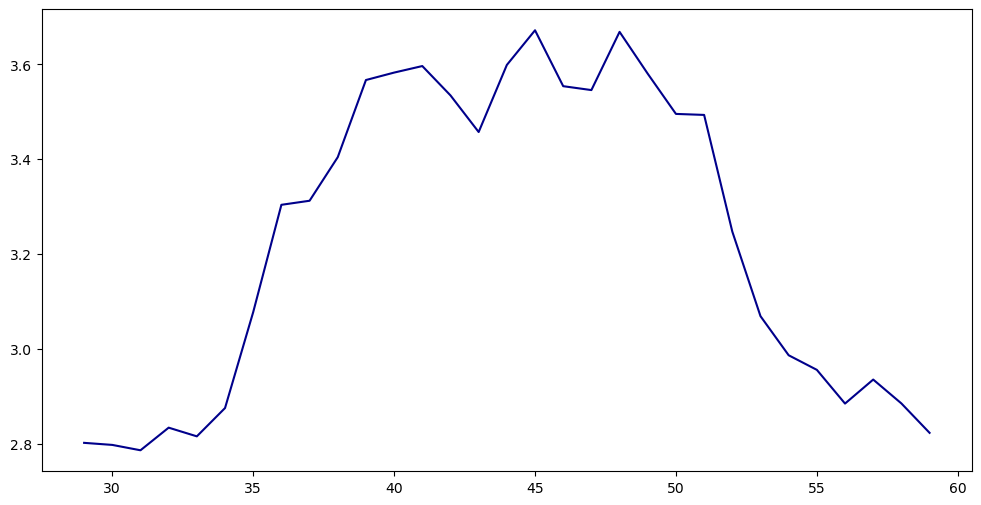

In [27]:
plt.figure(figsize=(12, 6))
rolling_rmse_30d.plot(label='30-Day Rolling RMSE', color='darkblue')

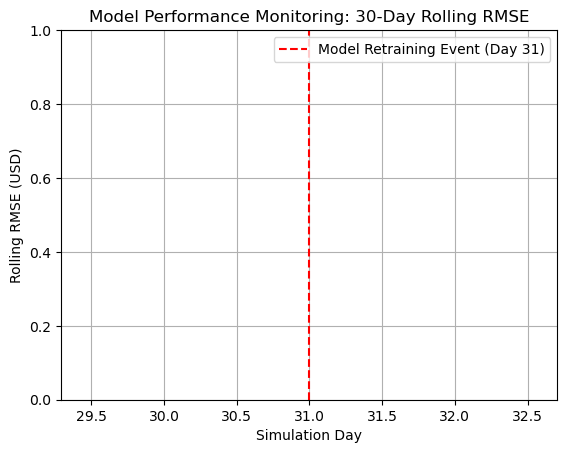

In [28]:
# Highlight the retraining point
plt.axvline(x=31, color='red', linestyle='--', label='Model Retraining Event (Day 31)')
plt.title('Model Performance Monitoring: 30-Day Rolling RMSE')
plt.xlabel('Simulation Day')
plt.ylabel('Rolling RMSE (USD)')
plt.legend()
plt.grid(True)
plt.show() 


In [29]:
# Train the final validated model on the full dataset
final_model = ARIMA(y, order=(5, 1, 0))
final_result = final_model.fit()
final_result

In [30]:
# --- 11. Final Diagnostics: Residual Plots ---
residuals = final_result.resid
residuals

Date
2012-10-30    85.680000
2012-10-31     0.560084
2012-11-01     0.974830
2012-11-02    -1.978421
2012-11-05     0.349602
                ...    
2022-10-24    -0.627341
2022-10-25     0.554808
2022-10-26     2.712997
2022-10-27     1.021602
2022-10-28    -0.005501
Length: 2548, dtype: float64

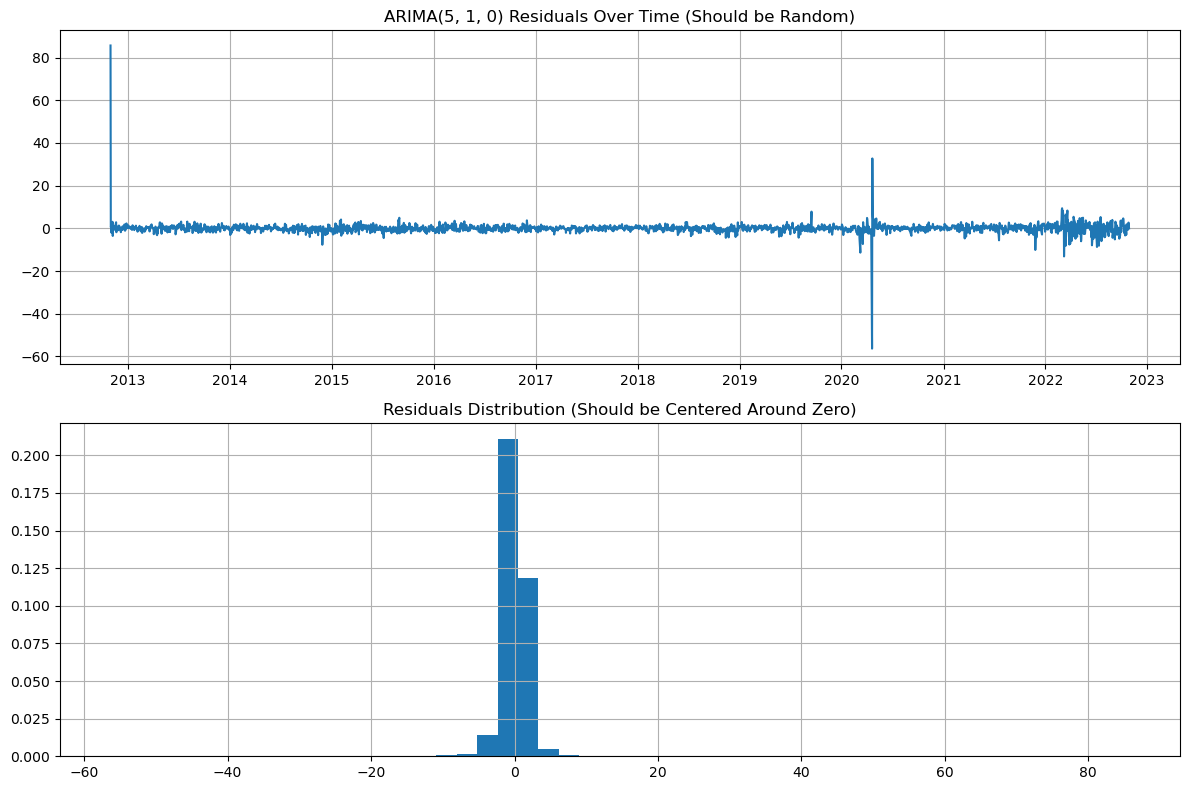

In [31]:
# 11a. Plot Residuals Time Series and Distribution
fig, axes = plt.subplots(2, 1, figsize=(12, 8))
axes[0].plot(residuals)
axes[0].set_title('ARIMA(5, 1, 0) Residuals Over Time (Should be Random)')
axes[0].grid(True)
residuals.hist(ax=axes[1], bins=50, density=True)
axes[1].set_title('Residuals Distribution (Should be Centered Around Zero)')
plt.tight_layout()
plt.savefig('Final_Residual_Distribution_Report.png')
plt.show()

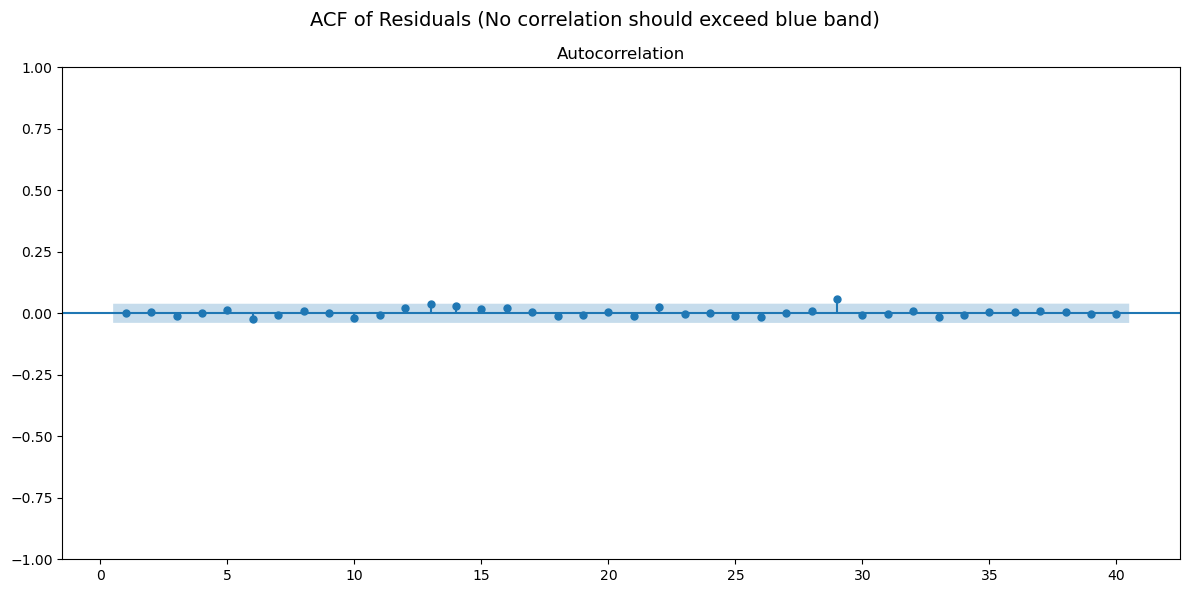

In [32]:
# 11b. ACF Plot of Residuals (Checking for Unmodeled Correlation)
fig_acf = plot_acf(residuals, lags=40, zero=False)
fig_acf.suptitle('ACF of Residuals (No correlation should exceed blue band)', fontsize=14)
fig_acf.set_size_inches(12, 6)
plt.tight_layout()
plt.savefig('Final_Residual_ACF_Report.png')
# plt.show()

In [33]:
# --- 12. Final Diagnostics: Ljung-Box Test (Statistical Proof) ---
# Tests the hypothesis that the residuals are independently distributed (i.e., white noise)
ljung_box_results = acorr_ljungbox(residuals, lags=[10, 20], return_df=True)
print("\n--- Ljung-Box Test for White Noise (Final Report Component) ---")
print("Null Hypothesis (H0): Residuals are independent (i.e., White Noise).")
print(ljung_box_results)
print("\nIf all p-values > 0.05, we accept H0 and the model is validated.")


--- Ljung-Box Test for White Noise (Final Report Component) ---
Null Hypothesis (H0): Residuals are independent (i.e., White Noise).
      lb_stat  lb_pvalue
10   3.106446   0.978807
20  12.944418   0.879756

If all p-values > 0.05, we accept H0 and the model is validated.


In [34]:
# --- 13. Final Forecast Summary (for Reporting) ---
forecast_steps = 30
forecast_result = final_result.get_forecast(steps=forecast_steps)
forecast_mean = forecast_result.predicted_mean
forecast_dates = pd.date_range(start=y.index[-1] + pd.Timedelta(days=1), periods=forecast_steps)

forecast_df = pd.DataFrame({
    'Date': forecast_dates,
    'Predicted_Close': forecast_mean.values,
})

print("\n--- 30-Day Final Forecast (Sample for Report) ---")
print(forecast_df.head())

print("\nFinal Model Report components generated (Residual Plots and Statistical Summary).")


--- 30-Day Final Forecast (Sample for Report) ---
        Date  Predicted_Close
0 2022-10-29        87.817597
1 2022-10-30        87.806807
2 2022-10-31        87.800874
3 2022-11-01        87.809039
4 2022-11-02        87.813518

Final Model Report components generated (Residual Plots and Statistical Summary).
